## Import relevant libraries and load the data

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns
from nltk.corpus import stopwords  # Remove useless words
# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Load the CSV

In [2]:
data = pd.read_csv('train.csv')
data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Entries with all 0 under the 6 categories are neutral and considered as non-toxic.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id                  159571 non-null object
comment_text        159571 non-null object
malignant           159571 non-null int64
highly_malignant    159571 non-null int64
rude                159571 non-null int64
threat              159571 non-null int64
abuse               159571 non-null int64
loathe              159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Its a clean dataset with no missing values.

In [4]:
data.columns

Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

## Let's see how the 3rd comments look like

In [5]:
data['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

Comments has '\n' values, symbols, numbers that will not be useful for analysis. We will be removing these further.

## Exploratory Data Analysis

In [6]:
# Check percentage of comments that are toxic compared to normal comments
data.malignant.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: malignant, dtype: float64

It seems that 90% of the comments fall in the toxic category.

In [7]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()

In [8]:
data_count

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

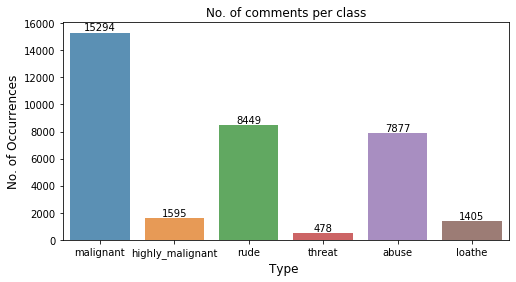

In [9]:
# Plot a bar chart using the index (category values) and the count of each category

plt.figure(figsize=(8,4))
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)
plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [10]:
num_rows = len(data)
print(num_rows)

159571


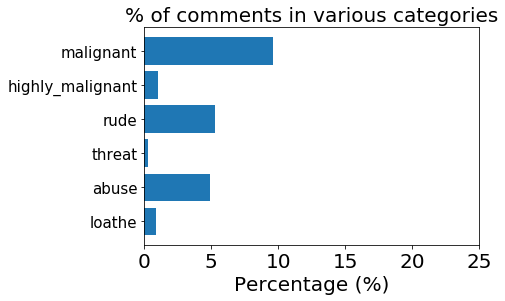

In [11]:
# Create a bar graph 
sum_mal = data['malignant'].sum() / num_rows * 100
sum_hig = data['highly_malignant'].sum() / num_rows * 100
sum_rude = data['rude'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_abu = data['abuse'].sum() / num_rows * 100
sum_loa = data['loathe'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_mal, sum_hig, sum_rude, sum_thr, sum_abu, sum_loa])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=20)
plt.yticks(ind, ('malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe' ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


## Preprocessing

In [12]:
# Text preprocessing steps - remove numbers, capital letters, punctuation and '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][3]

'  more i can t make any real suggestions on improvement   i wondered if the section statistics should be later on  or a subsection of   types of accidents     i think the references may need tidying so that they are all in the exact same format ie date format etc  i can do that later on  if no one else does first   if you have any preferences for formatting style on references or want to do it yourself please let me know   there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up  it s listed in the relevant form eg wikipedia good article nominations transport   '

## Separate our dataset into 6 sections. Each section is comment + 1 category.

In [13]:
data_mal = data.loc[:,['id','comment_text','malignant']]

In [14]:
data_mal['comment_text'][4]

'you  sir  are my hero  any chance you remember what page that s on '

In [15]:
data_hig = data.loc[:,['id','comment_text','highly_malignant']]

In [16]:
data_rude = data.loc[:,['id','comment_text','rude']]

In [17]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [18]:
data_abu = data.loc[:,['id','comment_text','abuse']]

In [19]:
data_loa = data.loc[:,['id','comment_text','loathe']]

## Creating WordCloud which is useful to show the words which occur most frequently for each category.

In [20]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

In [21]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)
    wc.generate(" ".join(text))

    plt.figure(figsize=(25,25))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(random_state=244), alpha=0.98)

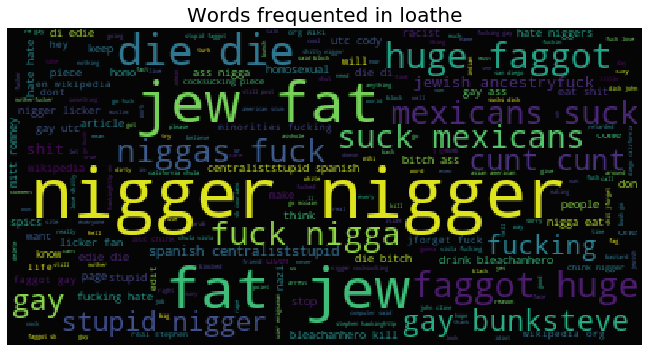

In [22]:
wordcloud(data_loa,'loathe')

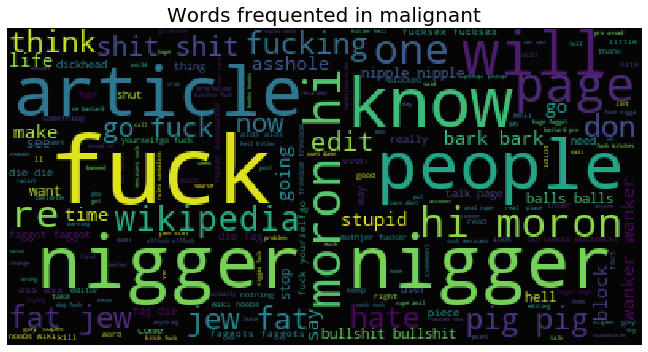

In [23]:
wordcloud(data_mal,'malignant')

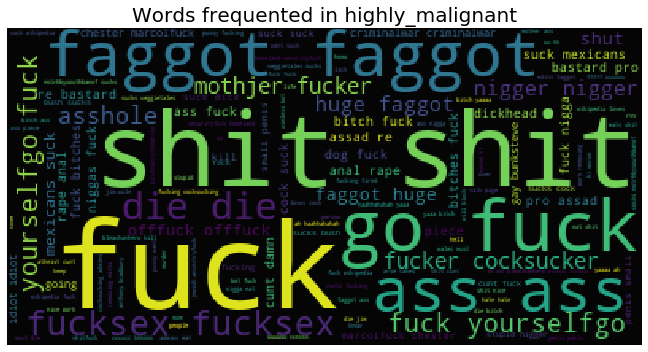

In [24]:
wordcloud(data_hig,'highly_malignant')

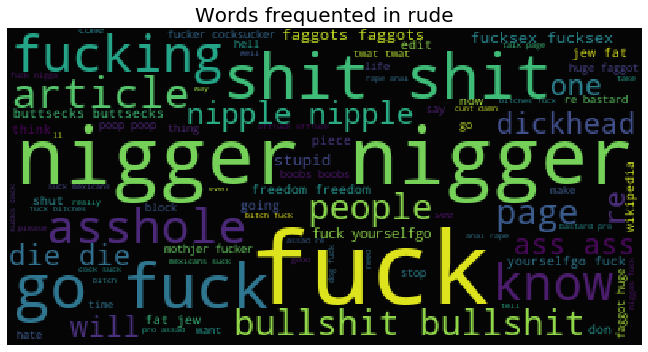

In [25]:
wordcloud(data_rude,'rude')

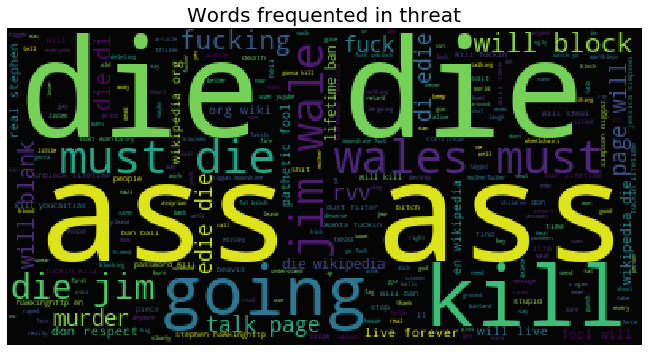

In [26]:
wordcloud(data_thr,'threat')

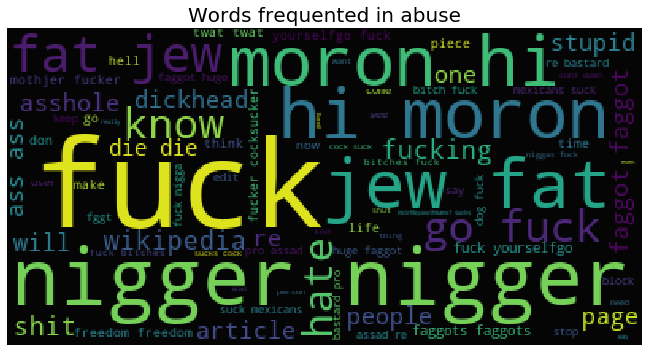

In [27]:
wordcloud(data_abu, 'abuse')

#### Earlier, we saw that comments that are toxic (and other forms of toxicity) make up less than 10% of the comments in the data. This leads to the issue of class imbalance.

#### We can deal with class imbalance by taking a subset of the data where the proportion of the toxic comments are at least 20% (ideally 50%) in relation to non-toxic comments.

#### For a start, we can take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have a balanced dataset.

In [28]:
data_mal.head()

,id,comment_text,malignant
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [29]:
data_mal_1 = data_mal[data_mal['malignant'] == 1].iloc[0:5000,:]
data_mal_1.shape

(5000, 3)

In [30]:
data_mal_0 = data_mal[data_mal['malignant'] == 0].iloc[0:5000,:]

In [31]:
data_mal_done = pd.concat([data_mal_1, data_mal_0], axis=0)
data_mal_done.shape

(10000, 3)

### Not all categories have 5000 rows. So we should count them first and make them balanced.

In [32]:
data_hig[data_hig['highly_malignant'] == 1].count()

id                  1595
comment_text        1595
highly_malignant    1595
dtype: int64

In [33]:
data_hig_1 = data_hig[data_hig['highly_malignant'] == 1].iloc[0:1595,:]
data_hig_0 = data_hig[data_hig['highly_malignant'] == 0].iloc[0:1595,:]
data_hig_done = pd.concat([data_hig_1, data_hig_0], axis=0)
data_hig_done.shape

(3190, 3)

We only had 1,595 comments that are highly_malignant. We combine it together with another 1,595 comments that are not toxic to form a new dataset that is balanced. We repeat this for all other categories.

In [34]:
data_rude[data_rude['rude'] == 1].count()

id              8449
comment_text    8449
rude            8449
dtype: int64

In [35]:
data_rude_1 = data_rude[data_rude['rude'] == 1].iloc[0:5000,:]
data_rude_0 = data_rude[data_rude['rude'] == 0].iloc[0:5000,:]
data_rude_done = pd.concat([data_rude_1, data_rude_0], axis=0)
data_rude_done.shape

(10000, 3)

In [36]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

The number of threat comments of 478 is too miniscule when addded with another 478 clean comments for a proper analysis. We decided that the clean comments will comprise 80% at the most of the dataset, as shown below.

In [37]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [38]:
data_abu[data_abu['abuse'] == 1].count()

id              7877
comment_text    7877
abuse           7877
dtype: int64

In [39]:
data_abu_1 = data_abu[data_abu['abuse'] == 1].iloc[0:5000,:]
data_abu_0 = data_abu[data_abu['abuse'] == 0].iloc[0:5000,:]
data_abu_done = pd.concat([data_abu_1, data_abu_0], axis=0)
data_abu_done.shape

(10000, 3)

In [40]:
data_loa[data_loa['loathe'] == 1].count()

id              1405
comment_text    1405
loathe          1405
dtype: int64

In [41]:
data_loa_1 = data_loa[data_loa['loathe'] == 1].iloc[0:1405,:] # 20%
data_loa_0 = data_loa[data_loa['loathe'] == 0].iloc[0:5620,:] # 80%
data_loa_done = pd.concat([data_loa_1, data_loa_0], axis=0)
data_loa_done.shape

(7025, 3)

### Import relevant packages for modelling

In [42]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


In [43]:
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [44]:
df_mal_cv = cv_tf_train_test(data_mal_done, 'malignant', TfidfVectorizer, (1,1))
df_mal_cv.rename(columns={'F1 Score': 'F1 Score(malignant)'}, inplace=True)

df_mal_cv

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done


,F1 Score(malignant)
Log Regression,0.860941
KNN,0.170616
BernoulliNB,0.776521
MultinomialNB,0.874958
SVM,0.876510
Random Forest,0.835621


In [45]:
df_hig_cv = cv_tf_train_test(data_hig_done, 'highly_malignant', TfidfVectorizer, (1,1))
df_hig_cv.rename(columns={'F1 Score': 'F1 Score(highly_malignant)'}, inplace=True)

df_hig_cv

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done


,F1 Score(highly_malignant)
Log Regression,0.927879
KNN,0.837809
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.927660


In [46]:
df_rude_cv = cv_tf_train_test(data_rude_done, 'rude', TfidfVectorizer, (1,1))
df_rude_cv.rename(columns={'F1 Score': 'F1 Score(rude)'}, inplace=True)

df_rude_cv

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done


,F1 Score(rude)
Log Regression,0.908655
KNN,0.410982
BernoulliNB,0.787830
MultinomialNB,0.901399
SVM,0.921378
Random Forest,0.907370


In [47]:
df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

df_thr_cv

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done


,F1 Score(threat)
Log Regression,0.628821
KNN,0.586207
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.800000


In [48]:
df_abu_cv = cv_tf_train_test(data_abu_done, 'abuse', TfidfVectorizer, (1,1))
df_abu_cv.rename(columns={'F1 Score': 'F1 Score(abuse)'}, inplace=True)

df_abu_cv

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done


,F1 Score(abuse)
Log Regression,0.896599
KNN,0.244898
BernoulliNB,0.783762
MultinomialNB,0.897411
SVM,0.902619
Random Forest,0.882616


In [49]:
df_loa_cv = cv_tf_train_test(data_loa_done, 'loathe', TfidfVectorizer, (1,1))
df_loa_cv.rename(columns={'F1 Score': 'F1 Score(loathe)'}, inplace=True)

df_loa_cv

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


lr done
bnb done
mnb done
rdf done


,F1 Score(loathe)
Log Regression,0.699029
KNN,0.197980
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.769821


In [50]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
final_all = pd.concat([df_mal_cv, df_hig_cv, df_rude_cv, df_abu_cv, df_thr_cv, df_loa_cv], axis=1)
final_all


,F1 Score(malignant),F1 Score(highly_malignant),F1 Score(rude),F1 Score(abuse),F1 Score(threat),F1 Score(loathe)
Log Regression,0.860941,0.927879,0.908655,0.896599,0.628821,0.699029
KNN,0.170616,0.837809,0.410982,0.244898,0.586207,0.197980
BernoulliNB,0.776521,0.803707,0.787830,0.783762,0.311828,0.549206
MultinomialNB,0.874958,0.936170,0.901399,0.897411,0.504762,0.485857
SVM,0.876510,0.926004,0.921378,0.902619,0.786765,0.797516
Random Forest,0.835621,0.927660,0.907370,0.882616,0.800000,0.769821


### Transpose the combined F1 dataframe to make it suitable for presentation on a graph

In [51]:
final_all_trp = final_all.transpose()
final_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(malignant),0.860941,0.170616,0.776521,0.874958,0.876510,0.835621
F1 Score(highly_malignant),0.927879,0.837809,0.803707,0.936170,0.926004,0.927660
F1 Score(rude),0.908655,0.410982,0.787830,0.901399,0.921378,0.907370
F1 Score(abuse),0.896599,0.244898,0.783762,0.897411,0.902619,0.882616
F1 Score(threat),0.628821,0.586207,0.311828,0.504762,0.786765,0.800000
F1 Score(loathe),0.699029,0.197980,0.549206,0.485857,0.797516,0.769821


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

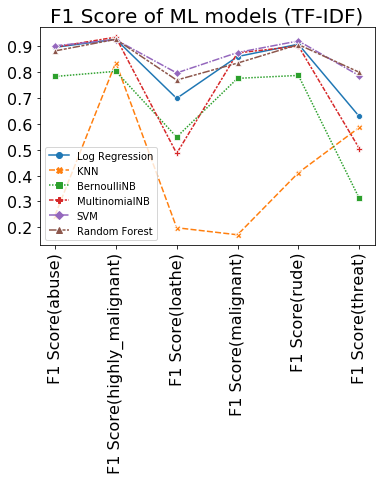

In [52]:
sns.lineplot(data=final_all_trp, size=[25,25], markers=True)
plt.xticks(rotation='90', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

# Repeat this for CountVectorizer as well

LinearSVM and Random Forest models perform best (purple and brown lines seem to be the highest).

### Test if our code actually works. Probability of the comment falling in various categories should be output.

In [53]:
data_mal_done.head()

,id,comment_text,malignant
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
12,0005c987bdfc9d4b,hey what is it talk what is it a...,1
16,0007e25b2121310b,bye don t look come or think of comming ba...,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1


In [54]:
X = data_mal_done.comment_text
y = data_mal_done['malignant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)



array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [55]:
test=pd.read_csv("test.csv")
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [56]:
# Sample Prediction
test_vect = tfv.transform(test['comment_text'])
randomforest.predict_proba(test_vect)[:,1]

array([0.92      , 0.12258283, 0.15674026, ..., 0.12492857, 0.1803355 ,
       0.7       ])

# Conclusion

LinearSVM and Random Forest models perform best (purple and brown lines seem to be the highest).